# Transactions Data Exploration

In [80]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### All the csv files are read and appended to 1 pandas dataframe.

In [81]:
path = r'./data/'                 
all_files = glob.glob(os.path.join(path, "*.csv"))   

df_from_each_file = (pd.read_csv(f) for f in all_files)
transactions_df   = pd.concat(df_from_each_file, ignore_index=True)

In [82]:
print('There are %d observations and %d columns' % (transactions_df.shape[0], transactions_df.shape[1]))

There are 63113 observations and 10 columns


### There are some missing values which will be dealt with

In [83]:
transactions_df.isnull().sum()

SKU Code        0
Brand Code     13
Category        9
Bill Number     0
Store Code      0
Sale Date       0
Sale/Return     0
MRP             0
Sales Price     0
Sales Qty       0
dtype: int64

### Converting date column to a datetime type

In [84]:
transactions_df['Sale Date'] =  pd.to_datetime(transactions_df['Sale Date'], format='%Y-%m-%d')

### First 5 observations of the dataframe.

In [85]:
transactions_df.head()

,SKU Code,Brand Code,Category,Bill Number,Store Code,Sale Date,Sale/Return,MRP,Sales Price,Sales Qty
0,SKU1181,BRAND041,Cat06,BILL06415,Store 1,2017-05-18,Return,0.01,0.01,-1
1,SKU0457,BRAND011,Cat01,BILL06416,Store 1,2017-05-22,Sale,72.00,72.67,2
2,SKU1465,BRAND018,Cat07,BILL06417,Store 1,2017-07-01,Return,20.00,20.00,-1
3,SKU0774,BRAND017,Cat07,BILL06418,Store 1,2017-07-01,Sale,30.67,30.67,1
4,SKU1695,BRAND017,Cat07,BILL06419,Store 1,2017-07-01,Sale,44.00,44.00,1


## Dealing with duplicates.

If SKU Code and Bill Number are the same they are duplicates. However we do not know which of the duplicates is to be removed. Hence a more structured approach is necessary.

### First we remove duplicates where all the column values are the same. 

In [86]:
transactions_deduplicated = transactions_df.drop_duplicates()

Number of rows has reduced.

In [87]:
transactions_deduplicated.shape

(55957, 10)

### There are some duplicates that show the same transaction but with sales price = 0 as shown below. These can be removed.

This table shows examples of such duplicates.

In [88]:
transactions_deduplicated[transactions_deduplicated.duplicated(subset=['SKU Code','Bill Number'],keep=False)].head()

,SKU Code,Brand Code,Category,Bill Number,Store Code,Sale Date,Sale/Return,MRP,Sales Price,Sales Qty
875,SKU0663,BRAND027,Cat04,BILL06868,Store 1,2017-07-29,Sale,1.33,1.33,1
877,SKU0663,BRAND027,Cat04,BILL06868,Store 1,2017-07-29,Sale,1.33,0.00,1
1530,SKU0632,BRAND027,Cat04,BILL07270,Store 1,2017-08-24,Sale,1.33,1.33,1
1538,SKU0632,BRAND027,Cat04,BILL07270,Store 1,2017-08-24,Sale,1.33,0.00,1
1997,SKU0640,BRAND027,Cat04,BILL07451,Store 1,2017-09-04,Sale,1.33,1.33,1


In [89]:
duplicate_indexes = transactions_deduplicated.index[transactions_deduplicated.duplicated(subset=['SKU Code','Bill Number'], 
                                                                  keep=False
                                                                 ) & 
                          (transactions_deduplicated['Sales Price']==0.00)]
transactions_deduplicated = transactions_deduplicated.drop(duplicate_indexes)

Number of rows has reduced.

In [90]:
transactions_deduplicated.shape

(55158, 10)

### There are some duplicates that show the same transaction but with sales qty = 0 as shown below. These can be removed.

In [91]:
duplicate_indexes = transactions_deduplicated.index[transactions_deduplicated.duplicated(subset=['SKU Code','Bill Number'], 
                                                                  keep=False
                                                                 ) & 
                          (transactions_deduplicated['Sales Qty']==0.00)]
transactions_deduplicated = transactions_deduplicated.drop(duplicate_indexes)

In [92]:
transactions_deduplicated.shape

(55152, 10)

In [93]:
transactions_deduplicated[transactions_deduplicated.duplicated(subset=['SKU Code','Bill Number'],keep=False)].shape[0]

122

There are 122 remaining but we dont know how to choose right one among the duplicates. We choose to keep the first one.

### Removing the final duplicates

In [94]:
transactions_deduplicated.drop_duplicates(subset=['SKU Code','Bill Number'], inplace=True)

## Rows with Sales Price > MRP

In [95]:
transactions_deduplicated[(transactions_deduplicated['Sales Price'] - transactions_deduplicated['MRP']) > 0].shape[0]

1629

There are 1629 transactions with sales price > MRP.

### Assuming sales price is recorded wrongly, we restrict the sales price's max value to MRP

In [96]:
transactions_deduplicated['Sales Price']  =  transactions_deduplicated.apply(lambda row: row['Sales Price'] if row['MRP'] >= row['Sales Price'] else row['MRP'], axis=1)

## Rows with MRP = 0 and Sales price = 0

### These have to be removed.

In [97]:
transactions_deduplicated[(transactions_deduplicated.MRP == 0) & (transactions_deduplicated['Sales Price'] == 0)].head()

,SKU Code,Brand Code,Category,Bill Number,Store Code,Sale Date,Sale/Return,MRP,Sales Price,Sales Qty
770,SKU1803,BRAND044,Cat07,BILL06833,Store 1,2017-07-29,Sale,0.0,0.0,1
773,SKU1798,BRAND044,Cat07,BILL06834,Store 1,2017-07-29,Sale,0.0,0.0,1
776,SKU1800,BRAND044,Cat07,BILL06835,Store 1,2017-07-29,Sale,0.0,0.0,1
779,SKU1798,BRAND044,Cat07,BILL06836,Store 1,2017-07-29,Sale,0.0,0.0,1
782,SKU1798,BRAND044,Cat07,BILL06837,Store 1,2017-07-29,Sale,0.0,0.0,1


In [98]:
transactions_deduplicated.drop(transactions_deduplicated[(transactions_deduplicated.MRP == 0) & (transactions_deduplicated['Sales Price'] == 0)].index,inplace=True)

## There are some category values that are missing. 

In [99]:
transactions_deduplicated['Category'].unique()

array(['Cat06', 'Cat01', 'Cat07', 'Cat04', 'Cat08', 'Cat03', 'Cat02',
       'Cat05', 'Cat09', nan, 'Cat11', 'Cat10'], dtype=object)

nan indicates missing value

In [100]:
skus_missing_cat = transactions_deduplicated['SKU Code'][transactions_deduplicated['Category'].isnull()]

### We do a check if the correct category values of these SKUs can be obtained from other rows.

### All instances of these SKUs have missing categories. These rows will be dropped when category column is used in the analysis.

In [101]:
transactions_deduplicated['Category'][transactions_deduplicated['SKU Code'].isin(skus_missing_cat)]

21861    NaN
23110    NaN
23204    NaN
23205    NaN
23266    NaN
23310    NaN
23314    NaN
23322    NaN
23338    NaN
Name: Category, dtype: object

### A function that plots heatmaps and returns aggregated statistics for the chosen parameters.

In [102]:
def grouping_and_heatmap(ax1,ax2,value,aggregation):
    grouped_transactions = transactions_deduplicated.groupby([ax1,ax2])[value].aggregate(aggregation).reset_index()
    grouped_transactions = grouped_transactions.pivot(index=ax1, columns=ax2, values=value)
    plt.figure(figsize=(12,6))
    sns.heatmap(grouped_transactions)
    plt.title('%s of %s' % (aggregation, value))
    plt.show()
    return grouped_transactions

### A discount and sale month columns are created to help our analysis

In [103]:
transactions_deduplicated['Discount']  = transactions_deduplicated.apply(lambda row: (row['MRP'] - row['Sales Price']) * 100 / row['MRP'], axis=1)
transactions_deduplicated['Sale Month']  = transactions_deduplicated['Sale Date'].dt.strftime('%m')

## Insights from data

## Heat map of average discount across stores and months
### Shows that highest discounts are during the ending months of the year followed by the starting months
### Store 2 has among the highest mean discounts.

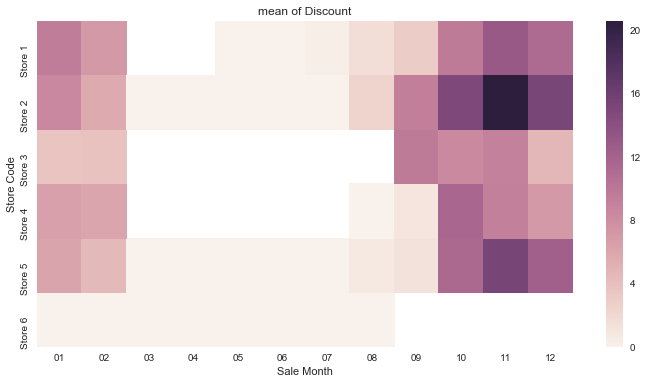

In [104]:
df_store_month_discount = grouping_and_heatmap("Store Code","Sale Month","Discount","mean")

### Table showing the mean discount across stores and months.

In [105]:
df_store_month_discount

Sale Month,01,02,03,04,05,06,07,08,09,10,11,12
Store Code,,,,,,,,,,,,
Store 1,9.525790,7.125200,NaN,NaN,0.000000,0.000000,0.296193,1.573741,3.033975,9.809415,13.029875,11.183224
Store 2,8.550540,5.757634,0.000000,0.000000,0.000000,0.000000,0.000000,2.481390,9.316770,14.879165,20.586682,15.261427
Store 3,3.589457,3.814758,NaN,NaN,NaN,NaN,NaN,NaN,9.757038,8.366894,9.112637,4.690741
Store 4,6.542201,6.053629,NaN,NaN,NaN,NaN,NaN,0.000000,1.025500,11.653188,9.205678,7.128066
Store 5,6.264604,4.545625,0.000000,0.000000,0.054304,0.013869,0.000000,0.680620,1.352860,11.464296,15.320130,12.352373
Store 6,0.000000,0.000000,0.067135,0.073801,0.038607,0.000000,0.052800,0.000000,NaN,NaN,NaN,NaN


## Heat map of total sales quantity across stores and months
### Shows that highest sales quantities are during the ending months of the year followed by the starting months
### Store 5 during Feb saw highest sales volume .

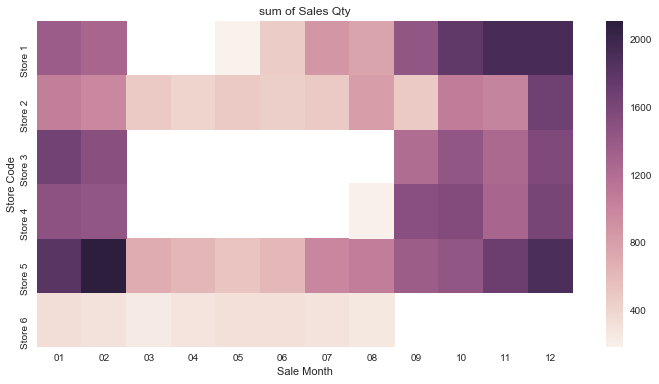

In [106]:
df_store_month_qty = grouping_and_heatmap("Store Code","Sale Month","Sales Qty","sum")

### Table showing the total sales quantity across stores and months.

In [107]:
df_store_month_qty

Sale Month,01,02,03,04,05,06,07,08,09,10,11,12
Store Code,,,,,,,,,,,,
Store 1,1375.0,1280.0,NaN,NaN,180.0,462.0,870.0,764.0,1439.0,1766.0,1923.0,1922.0
Store 2,1051.0,985.0,476.0,408.0,477.0,445.0,475.0,806.0,483.0,1073.0,1017.0,1669.0
Store 3,1657.0,1514.0,NaN,NaN,NaN,NaN,NaN,NaN,1219.0,1434.0,1257.0,1569.0
Store 4,1479.0,1446.0,NaN,NaN,NaN,NaN,NaN,190.0,1506.0,1553.0,1279.0,1621.0
Store 5,1811.0,2110.0,700.0,623.0,515.0,617.0,992.0,1063.0,1357.0,1439.0,1700.0,1906.0
Store 6,334.0,304.0,240.0,283.0,314.0,309.0,290.0,253.0,NaN,NaN,NaN,NaN


## Heat map of average selling price across stores and months
### Store 6 has most expensive products sold on average. Could be indication of higher income area.

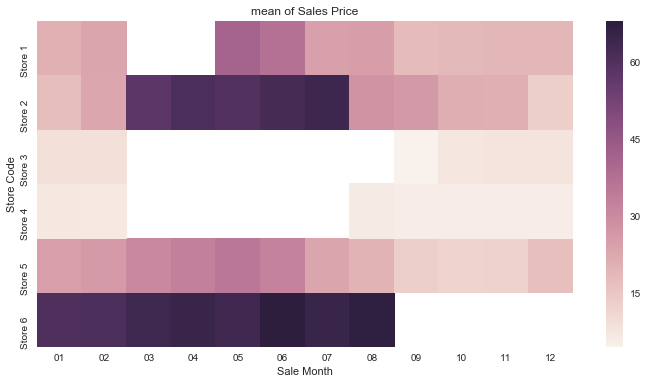

In [108]:
df_store_month_price = grouping_and_heatmap("Store Code","Sale Month","Sales Price","mean")

----------------

## Deep dive into categories.

### Dropping rows where category value is missing.

In [109]:
transactions_deduplicated.drop(transactions_deduplicated[transactions_deduplicated['Category'].isnull()].index,inplace=True)

### This function groups by store, month and category and aggregates the column given in argument. 
### Plots a barplot as well.

In [110]:
def store_month_category_grouping(value,aggregation):
    grouped_transactions = transactions_deduplicated.groupby(['Store Code','Sale Month','Category'])[value].aggregate(aggregation).reset_index()
    plt.figure(figsize=(15,8))
    grouped_transactions = grouped_transactions.sort_values(value,ascending=False).reset_index()
    sns.set(style="whitegrid")
    ax = sns.barplot(x=grouped_transactions[['Store Code', 'Sale Month','Category']].apply(lambda x: '-'.join(x), axis=1).head(8), y=value, data=grouped_transactions.head(8))
    plt.show()
    return grouped_transactions
    

-------------------------

## Average Discount

### Bar plot of mean discounts in each store-month-category.
### It is sorted and top 8 are displayed.
### Store 2 in November and category 4 had the highest average discounts
### Highest average discounts are in category 4.

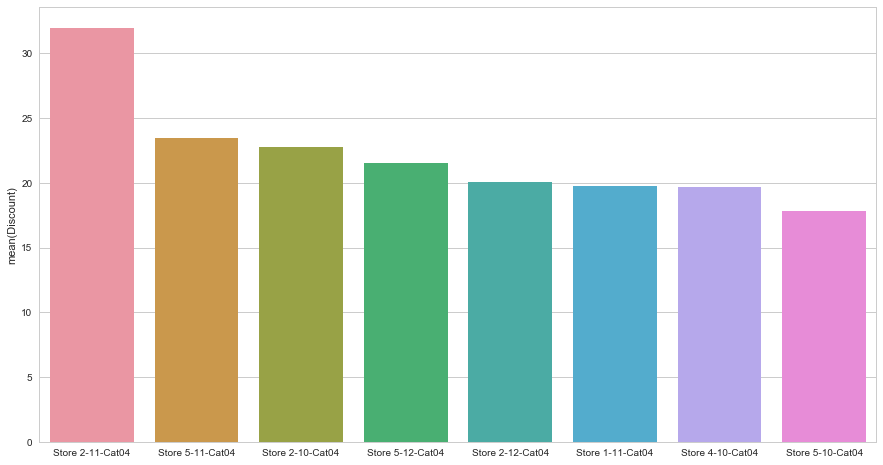

In [111]:
df_discounts = store_month_category_grouping("Discount","mean").sort_values("Discount",ascending=False).reset_index()

### Table of average discount for each store and each month.

In [112]:
df_discounts.head()

,level_0,index,Store Code,Sale Month,Category,Discount
0,0,113,Store 2,11,Cat04,31.985940
1,1,312,Store 5,11,Cat04,23.482764
2,2,106,Store 2,10,Cat04,22.738391
3,3,320,Store 5,12,Cat04,21.561922
4,4,120,Store 2,12,Cat04,20.064385


------------------------------------------------------

## Total Sales Quantities

### Bar plot of total sales quantities in each store-month-category.
### It is sorted and top 8 are displayed.
### Store 1 in December and category 4 had the highest average discounts
### Again category 4 comes among the top in sales quantities.

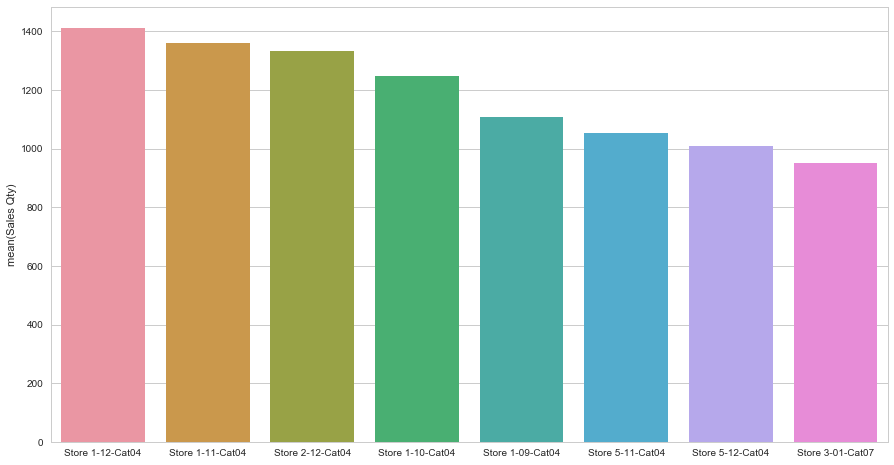

In [113]:
df_salesQty = store_month_category_grouping("Sales Qty","sum")

### Table of total sales quantities for each store, month and category

In [114]:
df_salesQty.head()

,index,Store Code,Sale Month,Category,Sales Qty
0,43,Store 1,12,Cat04,1413
1,38,Store 1,11,Cat04,1362
2,120,Store 2,12,Cat04,1334
3,34,Store 1,10,Cat04,1248
4,29,Store 1,09,Cat04,1108


--------------------------

## Average Sales Price

### Bar plot of average sales price in each store-month-category.
### It is sorted and top 8 are displayed.
### Store 1 in November and category 8 had the highest average sales price.
### Category 8 has the highest sales prices.

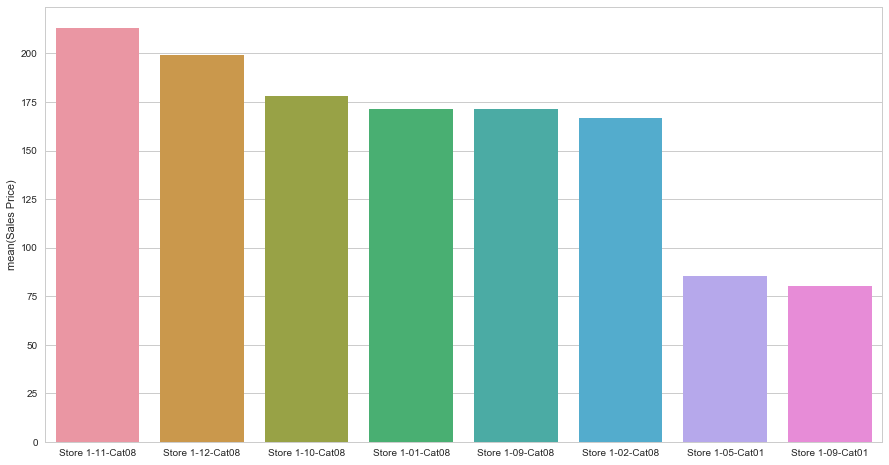

In [115]:
df_salesPrice = store_month_category_grouping("Sales Price","mean").head()

### Table of average sales price for each store, month and category

In [116]:
df_salesPrice.head()

,index,Store Code,Sale Month,Category,Sales Price
0,41,Store 1,11,Cat08,213.320
1,46,Store 1,12,Cat08,199.322
2,36,Store 1,10,Cat08,178.325
3,5,Store 1,01,Cat08,171.326
4,32,Store 1,09,Cat08,171.326


--------------------

##  Assuming each brand has 50% margin - which are the top contributing brands to the profits of the retailer?

### A profit column is made.

In [117]:
margin = 0.5
transactions_deduplicated['Profit']  = transactions_deduplicated.apply(lambda row: ((margin * row['Sales Price'])/(1+margin)) * row['Sales Qty'], axis=1)

### A dataframe with aggregated brand profits is made and sorted.

In [118]:
aggregated_brand_profits = transactions_deduplicated.groupby(['Brand Code'])['Profit'].aggregate("sum").sort_values(ascending=False).reset_index()

### Top 10 brands in profits

In [119]:
aggregated_brand_profits.head(10)

,Brand Code,Profit
0,BRAND017,53299.083333
1,BRAND018,37037.793333
2,BRAND001,25294.190000
3,BRAND003,23037.170000
4,BRAND011,18461.876667
5,BRAND007,16516.180000
6,BRAND005,15399.173333
7,BRAND027,14614.700000
8,BRAND002,12848.250000
9,BRAND034,11078.090000


### Bar plot of the top profit contributing brands 

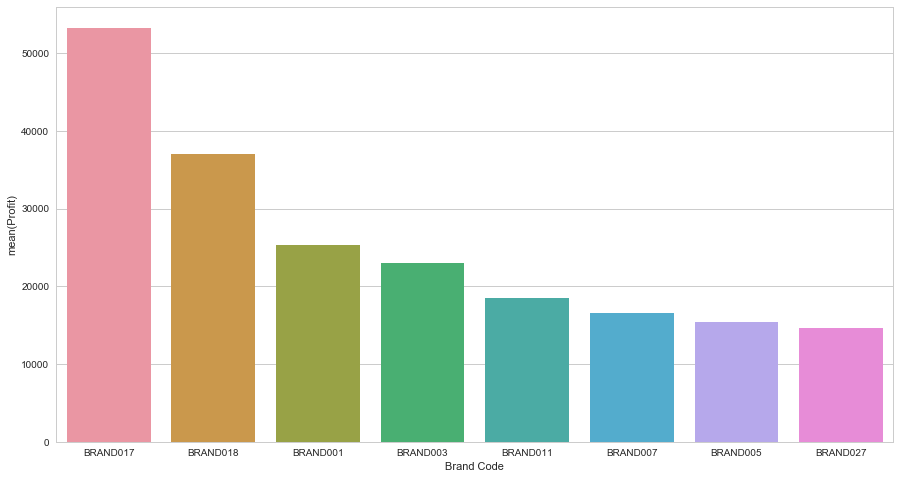

In [120]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x='Brand Code', y='Profit', data=aggregated_brand_profits.head(8))
plt.show()

------------------------------------------------------------------------------------------------

## Highest Revenue Generating Store

### Creating a revenue column by multiplying SP and Qty.

In [121]:
transactions_deduplicated['Revenue']  = transactions_deduplicated.apply(lambda row: row['Sales Price'] * row['Sales Qty'], axis=1)

### A dataframe with aggreagated revenue for each store is made and sorted.

In [122]:
aggregated_store_revenue = transactions_deduplicated.groupby(['Store Code'])['Revenue'].aggregate("sum").sort_values(ascending=False).reset_index()

### Barplot of stores and revenues.
### Store 5 has the highest revenue

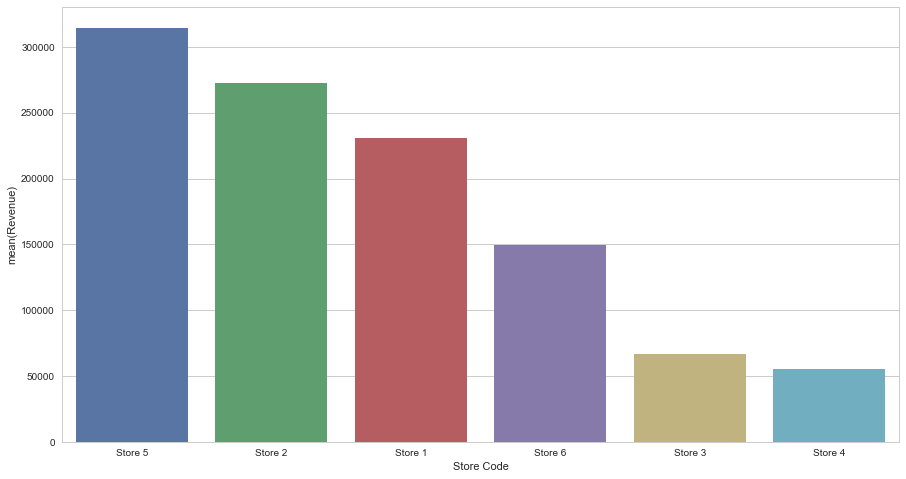

In [123]:
plt.figure(figsize=(15,8))
sns.set(style="whitegrid")
ax = sns.barplot(x='Store Code', y='Revenue', data=aggregated_store_revenue)
plt.show()

### Digging in further.

## Store 5 had really high turnover in February and January. December also saw really high revenue.

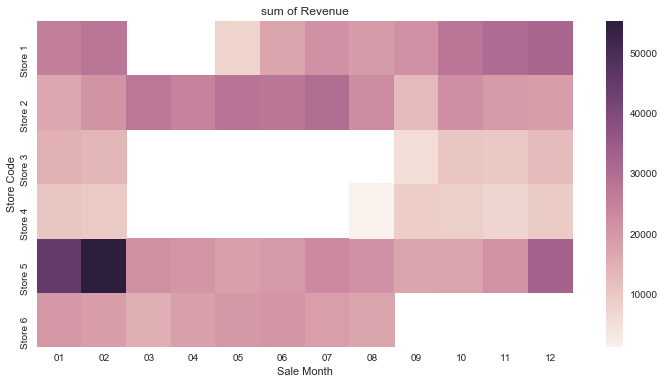

Sale Month,01,02,03,04,05,06,07,08,09,10,11,12
Store Code,,,,,,,,,,,,
Store 1,25941.24,27711.88,NaN,NaN,7512.66,17188.45,21619.31,19346.05,21542.66,27749.58,30751.95,31698.51
Store 2,16769.58,21063.42,27477.16,24946.62,28514.22,27782.41,30402.12,22523.66,12795.33,22107.55,19214.75,18795.74
Store 3,14761.95,13515.49,NaN,NaN,NaN,NaN,NaN,NaN,5415.18,10322.18,10006.93,12498.00
Store 4,10465.12,9764.61,NaN,NaN,NaN,NaN,NaN,1207.55,8893.69,8609.62,7306.21,9417.43
Store 5,45157.38,55368.58,21748.52,20525.53,18281.79,19820.40,23112.74,21623.21,17410.52,17540.44,21230.87,32794.89
Store 6,20234.76,18822.27,15112.84,18419.19,19895.94,20873.10,18636.61,17148.56,NaN,NaN,NaN,NaN


In [124]:
grouping_and_heatmap("Store Code","Sale Month","Revenue","sum")



## Store 5 saw most turnover in category 1 and category7

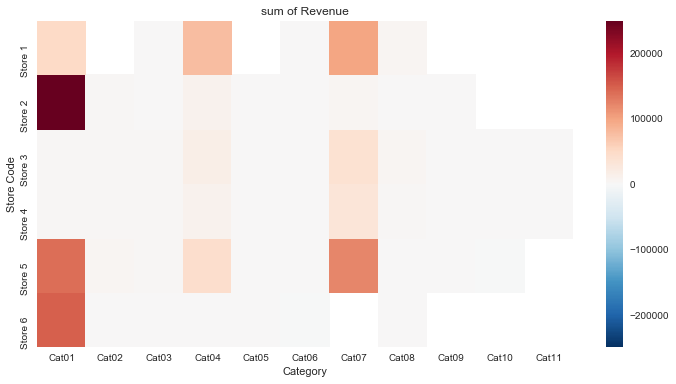

Category,Cat01,Cat02,Cat03,Cat04,Cat05,Cat06,Cat07,Cat08,Cat09,Cat10,Cat11
Store Code,,,,,,,,,,,
Store 1,50077.94,NaN,322.67,76150.03,NaN,838.69,98539.88,5133.08,NaN,NaN,NaN
Store 2,248685.30,3173.06,1835.86,11180.29,722.73,140.34,5751.68,722.52,180.78,NaN,NaN
Store 3,2926.30,2085.34,2479.25,15770.69,795.66,9.27,37903.83,3905.20,71.37,296.54,276.28
Store 4,3206.61,2217.64,2178.61,10954.63,762.09,19.34,32244.10,3743.56,85.13,164.78,87.74
Store 5,138223.95,4455.36,2344.87,43936.08,799.76,1006.23,122321.27,1154.02,373.43,-0.10,NaN
Store 6,148183.92,339.59,282.41,62.10,199.88,-0.01,NaN,75.38,NaN,NaN,NaN


In [125]:
grouping_and_heatmap("Store Code","Category","Revenue","sum")